In [1]:
setwd('/import/DB/fel/BJTC-204/')

In [2]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [3]:
da1 = readRDS('../final.rds')

In [4]:
sce1 = da1

In [6]:
table(sce1@meta.data$celltype)


  Ast   End   ExN   InN   Mic   Mix   OPC   Oli 
13210  3948 77458 28336  3744  3800  7678 22537 

In [7]:
library(CellChat)
library(patchwork)

Loading required package: dplyr

Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'patchwork' was built under R version 4.2.3"


In [8]:
Idents(sce1) = 'Condition'

In [9]:
table(sce1$Condition)


   Case Control 
  93273   67438 

In [12]:
Idents(sce1) = 'Condition'
Case = subset(sce1,idents = 'Case')
Control = subset(sce1,idents = 'Control')

In [ ]:
cellchat <- createCellChat(object = Case,
                           meta = Case@meta.data,
                           group.by = "celltype")
cellchat

CellChatDB <- CellChatDB.human 
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") 
# set the used database in the object
cellchat@DB <- CellChatDB.use

library(future)
cellchat <- subsetData(cellchat) 
# do parallel ，根据配置设置
plan(multisession, workers=50)
cellchat <- identifyOverExpressedGenes(cellchat)
#识别过表达配体受体对
cellchat <- identifyOverExpressedInteractions(cellchat)

#project gene expression data onto PPI (Optional: when running it, USER should set `raw.use = FALSE` in the function `computeCommunProb()` in order to use the projected data)
cellchat <- projectData(cellchat, PPI.human)
library(future)
options(future.globals.maxSize= 400000000000)
cellchat <- computeCommunProb(cellchat, raw.use = TRUE, population.size = TRUE) 
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 1)
df.net <- subsetCommunication(cellchat)

cellchat <- aggregateNet(cellchat)
#计算每种细胞各有多少个
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, 
                     label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, 
                     label.edge= F, title.name = "Interaction weights/strength")

mat <- cellchat@net$count
par(mfrow = c(3,3), xpd=TRUE)
for (i in 1:nrow(mat)) {
  # i = 1
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                    arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}
# save as TIL/net_number_individual.pdf

## 运行上述代码出现报错 Error in plot.new() : figure margins too large
# par("mar")
## [1] 5.1 4.1 4.1 2.1
# par(mar=c(1,1,1,1))
# 重新运行上面的代码

mat <- cellchat@net$weight
par(mfrow = c(3,3), xpd=T)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                   arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}
# save as TIL/net_strength_individual.pdf

mat <- cellchat@net$weight
par(mfrow = c(2,3), xpd=T)
for (i in 1:nrow(mat)) {
      mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
      mat2[i, ] <- mat[i, ]
      netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                       arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
    }
# save as TIL/net_strength_individual.pdf

cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)

cellchat@netP$pathways#查看都有哪些信号通路
# [1] "TGFb"       "NRG"        "PDGF"       "CCL"        "CXCL"       "MIF"        "IL2"        "IL6"       
# [9] "IL10"       "IL1"        "CSF"        "IL16"       "IFN-II"     "LT"         "LIGHT"      "FASLG"     
# [17] "TRAIL"      "BAFF"       "CD40"       "VISFATIN"   "COMPLEMENT" "PARs"       "FLT3"       "ANNEXIN"   
# [25] "GAS"        "GRN"        "GALECTIN"   "BTLA"       "BAG"     
# 选择其中一个信号通路，比如说TGFb


pathways.show <- cellchat@netP$pathways 

# levels(cellchat@idents)    # show all celltype
# # [1] "Naive CD4 T"  "Memory CD4 T" "CD14+ Mono"   "B"            "CD8 T"       
# # [6] "FCGR3A+ Mono" "NK"           "DC"           "Platelet"    
# vertex.receiver = c(1,2,4,6) # define a numeric vector （淋系细胞）giving the index of the celltype as targets
# #par(mar=c(5.1,4.1,4.1,2.1))
# netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver)
# save as TIL/CXCL_hierarchy.pdf

par(mfrow=c(1,1))
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "chord")
# save as TIL/CXCL_chord.pdf

#计算配体受体对选定信号通路的贡献值（在这里就是查看哪条信号通路对TGFb贡献最大）
netAnalysis_contribution(cellchat, signaling = pathways.show)
pairLR.TGFb <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE) #提取对TGFb有贡献的所有配体受体 
# save as TIL/CXCL_LR_contribution.pdf

#提取对这个通路贡献最大的配体受体对来展示（也可以选择其他的配体受体对）
LR.show <- pairLR.TGFb[1,] 
vertex.receiver = c(1,2,4,6) # a numeric vector
netVisual_individual(cellchat, signaling = pathways.show,  pairLR.use = LR.show, vertex.receiver = vertex.receiver)
# save as TIL/CXCL_hierarchy2.pdf

levels(cellchat@idents)
# show all the significant interactions (L-R pairs)
#需要指定受体细胞和配体细胞
p = netVisual_bubble(cellchat, sources.use = c(3,5,7,8,9), 
                     targets.use = c(1,2,4,6), remove.isolate = FALSE)
#ggsave("Mye_Lymph_bubble.pdf", p, width = 8, height = 12) #髓系对淋巴的调节
# save as TIL/Mye_Lymph_bubble.pdf

cellchat <- computeCommunProbPathway(cellchat)

cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")

netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, 
                                   width = 15, height = 6, font.size = 10)
# # save as TIL/SNA_CXCL_signalingRole.pdf

In [47]:
write.csv(df.net, "cell-cell_communications.all.case.csv")
saveRDS(cellchat,file =  'case.cellchat.rds')

### control

[1] "Create a CellChat object from a Seurat object"
The `data` slot in the default assay is used. The default assay is RNA 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Ast End ExN InN Mic Mix OPC Oli 


An object of class CellChat created from a single dataset 
 33562 genes.
 67438 cells. 
CellChat analysis of single cell RNA-seq data! 

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-06-19 02:46:26]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-06-19 03:01:37]"


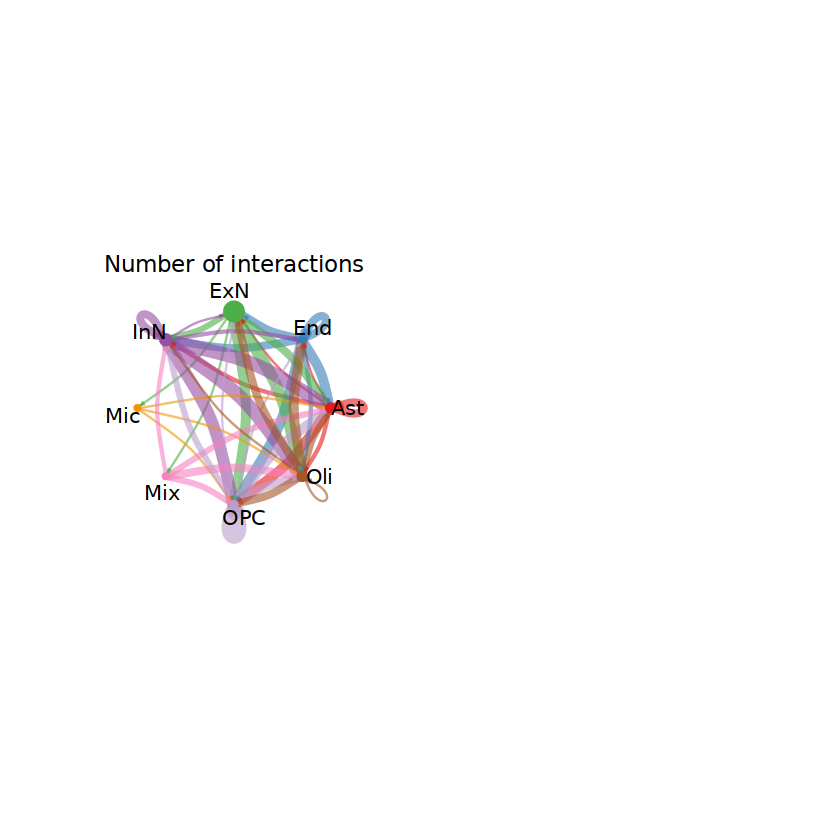

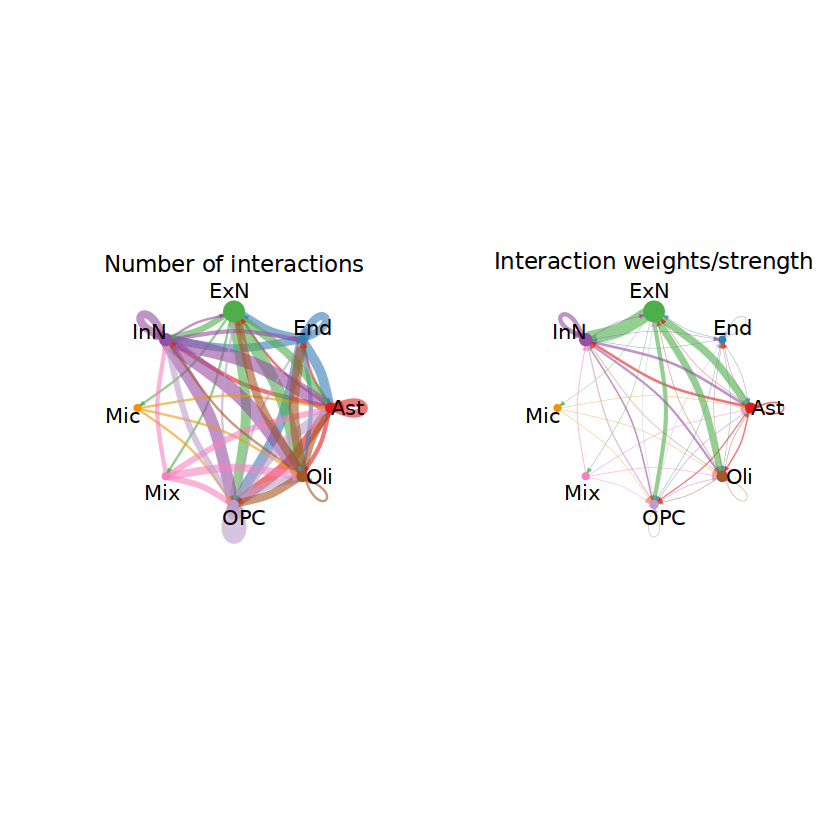

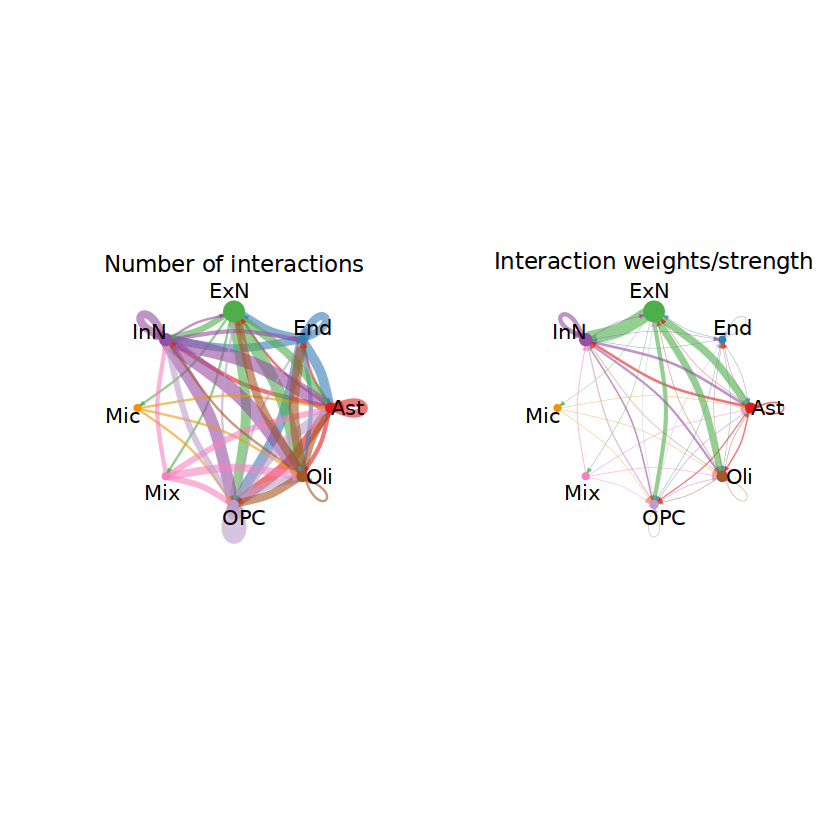

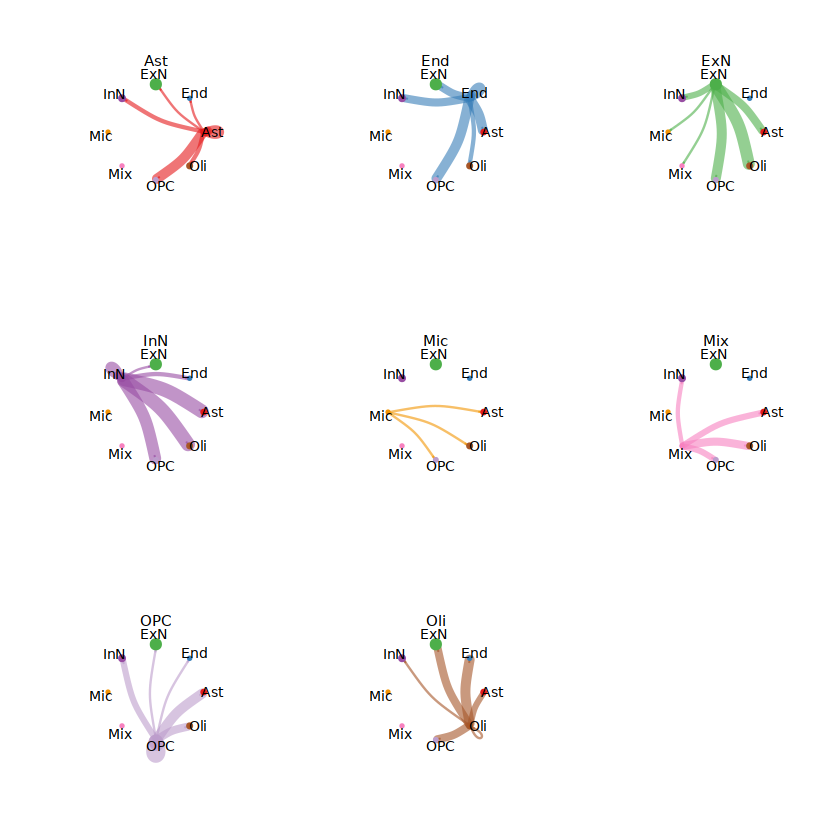

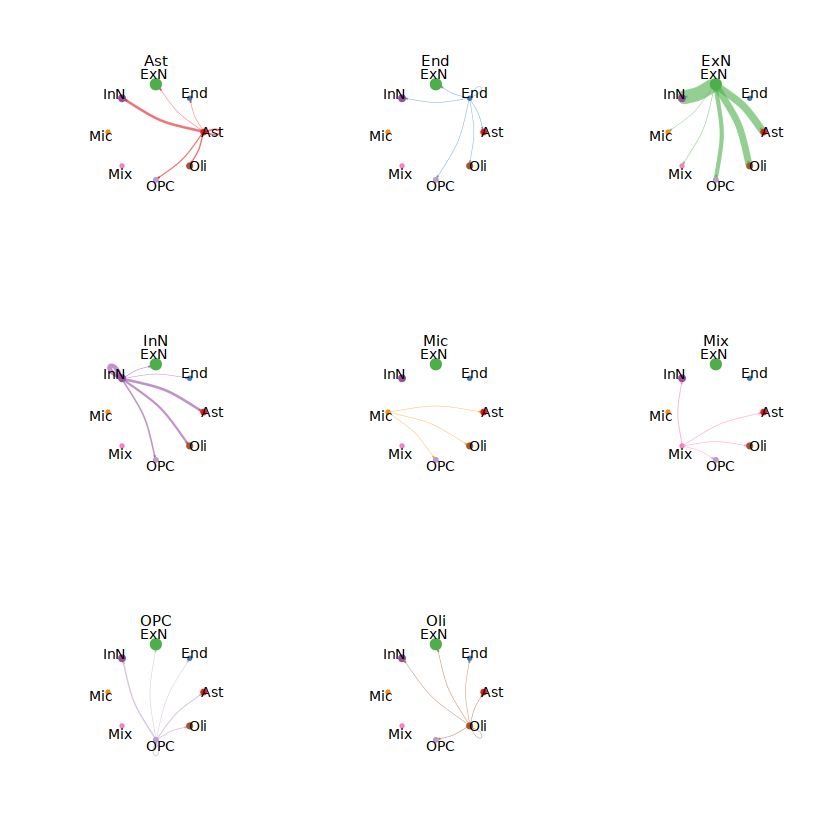

[1] "NRG"      "PTN"      "PSAP"     "IGF"      "SEMA3"    "PDGF"    
 [7] "FGF"      "BMP"      "VISFATIN" "SPP1"     "CX3C"

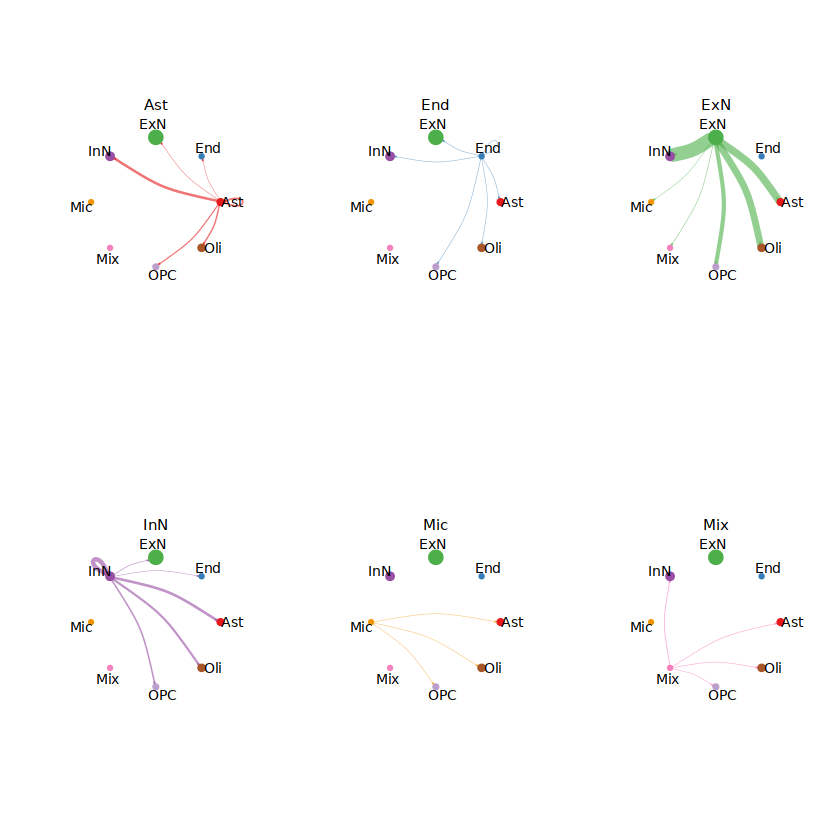

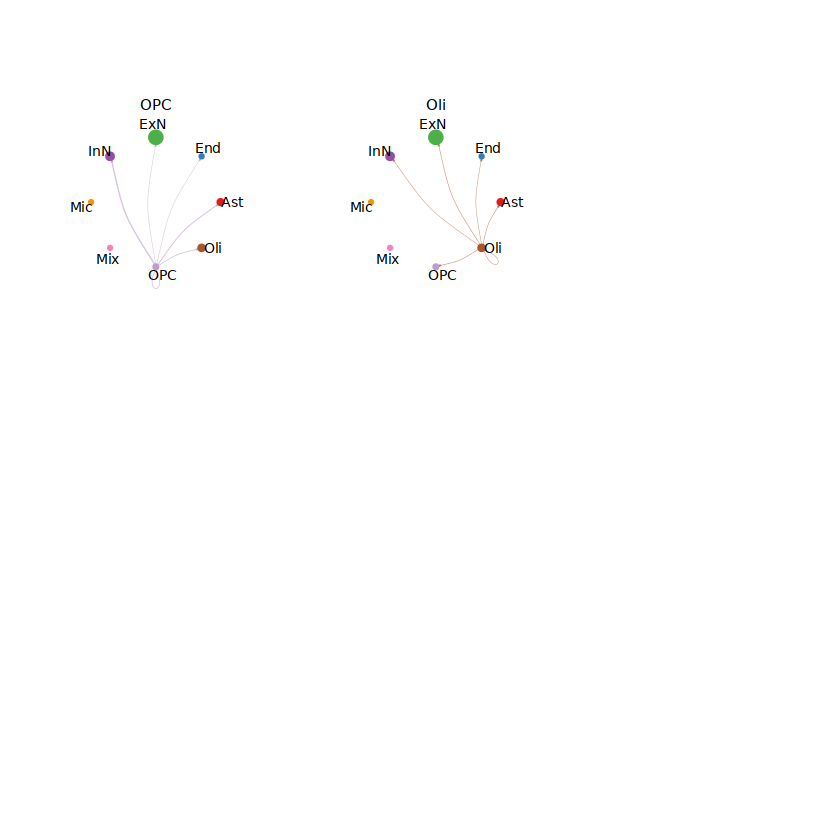

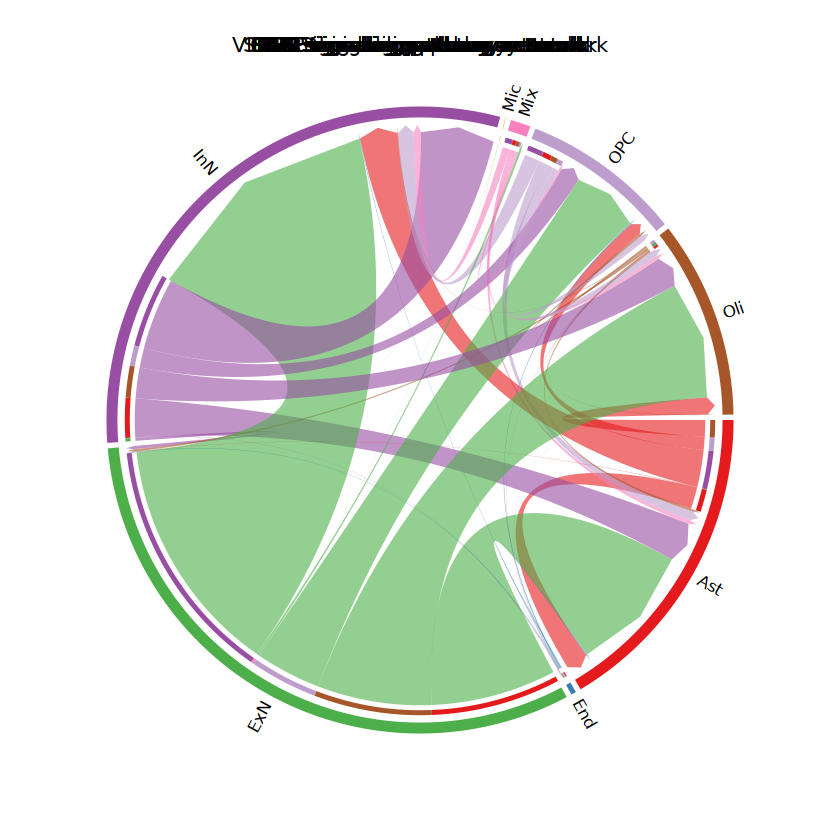

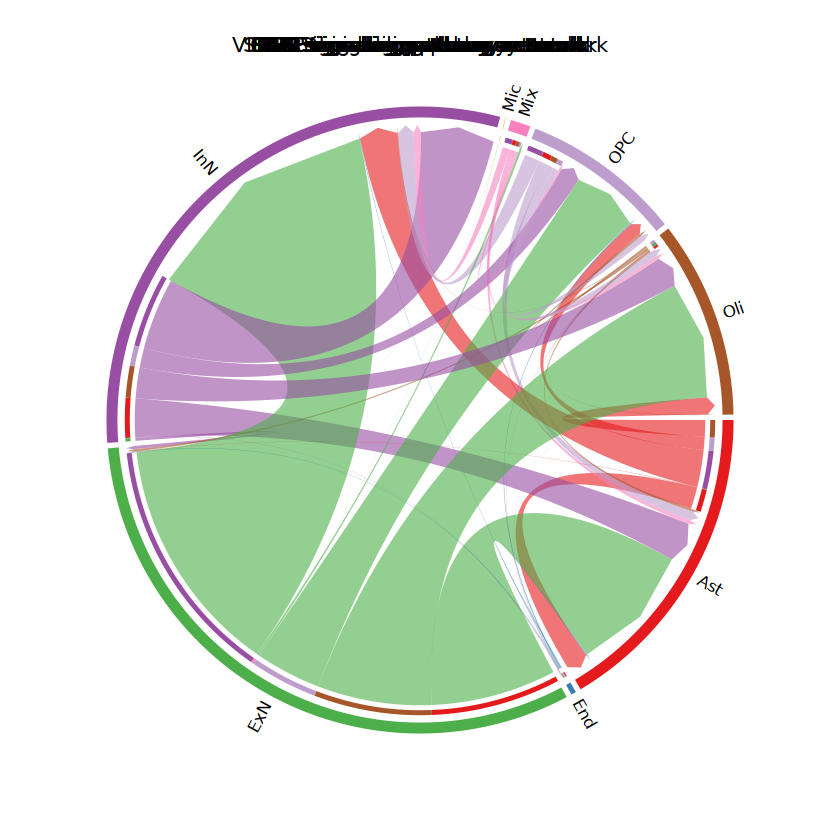

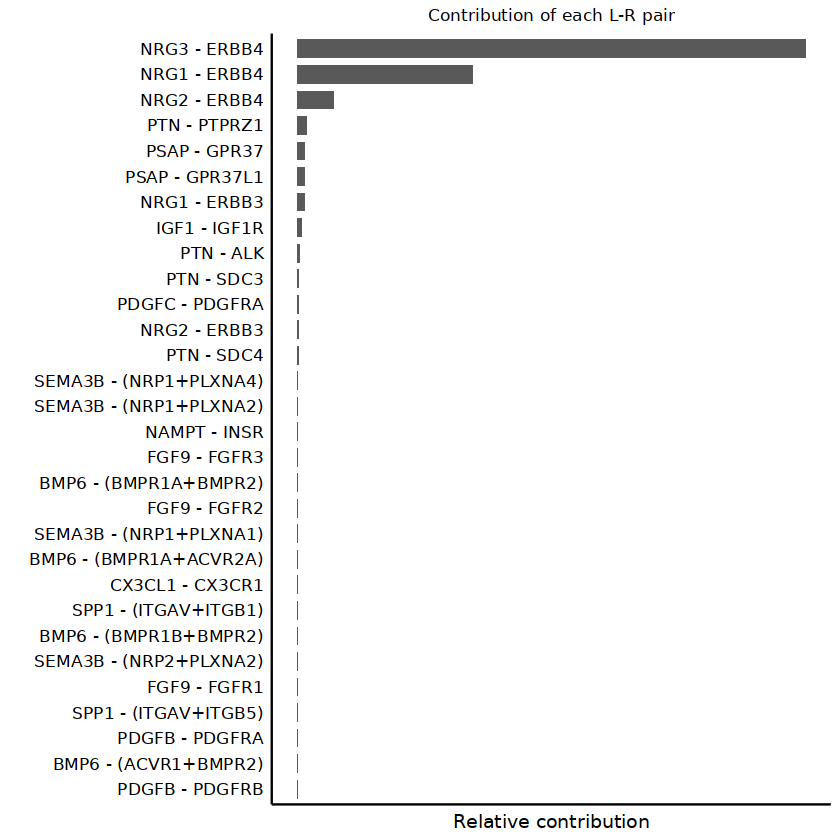

[[1]]


[1] "Ast" "End" "ExN" "InN" "Mic" "Mix" "OPC" "Oli"

Comparing communications on a single object 




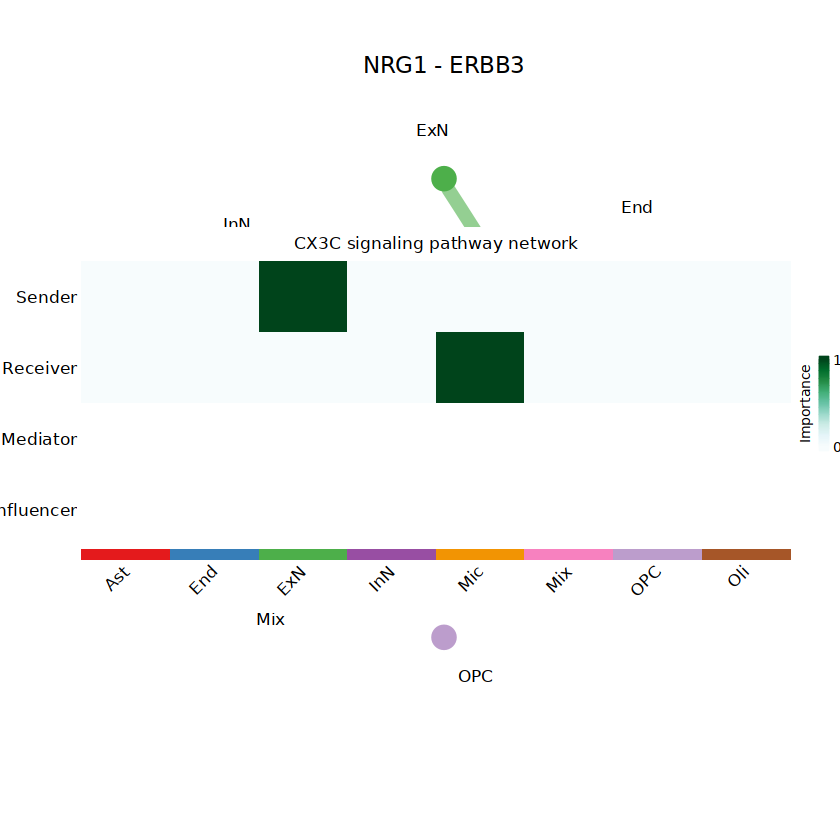

In [49]:
cellchat <- createCellChat(object = Control,
                           meta = Control@meta.data,
                           group.by = "celltype")
cellchat

CellChatDB <- CellChatDB.human 
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") 
# set the used database in the object
cellchat@DB <- CellChatDB.use

library(future)
cellchat <- subsetData(cellchat) 
# do parallel ，根据配置设置
plan(multisession, workers=50)
cellchat <- identifyOverExpressedGenes(cellchat)
#识别过表达配体受体对
cellchat <- identifyOverExpressedInteractions(cellchat)

#project gene expression data onto PPI (Optional: when running it, USER should set `raw.use = FALSE` in the function `computeCommunProb()` in order to use the projected data)
cellchat <- projectData(cellchat, PPI.human)
library(future)
options(future.globals.maxSize= 400000000000)
cellchat <- computeCommunProb(cellchat, raw.use = TRUE, population.size = TRUE) 
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 1)
df.net <- subsetCommunication(cellchat)

cellchat <- aggregateNet(cellchat)
#计算每种细胞各有多少个
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, 
                     label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, 
                     label.edge= F, title.name = "Interaction weights/strength")

mat <- cellchat@net$count
par(mfrow = c(3,3), xpd=TRUE)
for (i in 1:nrow(mat)) {
  # i = 1
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                    arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}
# save as TIL/net_number_individual.pdf

## 运行上述代码出现报错 Error in plot.new() : figure margins too large
# par("mar")
## [1] 5.1 4.1 4.1 2.1
# par(mar=c(1,1,1,1))
# 重新运行上面的代码

mat <- cellchat@net$weight
par(mfrow = c(3,3), xpd=T)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                   arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}
# save as TIL/net_strength_individual.pdf

mat <- cellchat@net$weight
par(mfrow = c(2,3), xpd=T)
for (i in 1:nrow(mat)) {
      mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
      mat2[i, ] <- mat[i, ]
      netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                       arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
    }
# save as TIL/net_strength_individual.pdf

cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)

cellchat@netP$pathways#查看都有哪些信号通路
# [1] "TGFb"       "NRG"        "PDGF"       "CCL"        "CXCL"       "MIF"        "IL2"        "IL6"       
# [9] "IL10"       "IL1"        "CSF"        "IL16"       "IFN-II"     "LT"         "LIGHT"      "FASLG"     
# [17] "TRAIL"      "BAFF"       "CD40"       "VISFATIN"   "COMPLEMENT" "PARs"       "FLT3"       "ANNEXIN"   
# [25] "GAS"        "GRN"        "GALECTIN"   "BTLA"       "BAG"     
# 选择其中一个信号通路，比如说TGFb


pathways.show <- cellchat@netP$pathways 

# levels(cellchat@idents)    # show all celltype
# # [1] "Naive CD4 T"  "Memory CD4 T" "CD14+ Mono"   "B"            "CD8 T"       
# # [6] "FCGR3A+ Mono" "NK"           "DC"           "Platelet"    
# vertex.receiver = c(1,2,4,6) # define a numeric vector （淋系细胞）giving the index of the celltype as targets
# #par(mar=c(5.1,4.1,4.1,2.1))
# netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver)
# save as TIL/CXCL_hierarchy.pdf

par(mfrow=c(1,1))
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "chord")
# save as TIL/CXCL_chord.pdf

#计算配体受体对选定信号通路的贡献值（在这里就是查看哪条信号通路对TGFb贡献最大）
netAnalysis_contribution(cellchat, signaling = pathways.show)
pairLR.TGFb <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE) #提取对TGFb有贡献的所有配体受体 
# save as TIL/CXCL_LR_contribution.pdf

#提取对这个通路贡献最大的配体受体对来展示（也可以选择其他的配体受体对）
LR.show <- pairLR.TGFb[1,] 
vertex.receiver = c(1,2,4,6) # a numeric vector
netVisual_individual(cellchat, signaling = pathways.show,  pairLR.use = LR.show, vertex.receiver = vertex.receiver)
# save as TIL/CXCL_hierarchy2.pdf

levels(cellchat@idents)
# show all the significant interactions (L-R pairs)
#需要指定受体细胞和配体细胞
p = netVisual_bubble(cellchat, sources.use = c(3,5,7,8,9), 
                     targets.use = c(1,2,4,6), remove.isolate = FALSE)
#ggsave("Mye_Lymph_bubble.pdf", p, width = 8, height = 12) #髓系对淋巴的调节
# save as TIL/Mye_Lymph_bubble.pdf

cellchat <- computeCommunProbPathway(cellchat)

cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")

netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, 
                                   width = 15, height = 6, font.size = 10)
# # save as TIL/SNA_CXCL_signalingRole.pdf

In [51]:
write.csv(df.net, "cell-cell_communications.all.Control.csv")
saveRDS(cellchat,file =  'Control.cellchat.rds')